In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import statistics
import matplotlib.pyplot as plt

# Load feature table

In [2]:
df = pd.read_csv('./data/16_over_feature_with_label_all_48H.csv')

In [3]:
df.shape

(224951, 338)

# Use admissions and patient tables to filter patient population

In [4]:
admissions_df = pd.read_csv('./data/admissions.csv')
admissions_df['HOSPITAL_EXPIRE_FLAG'].value_counts()

0    53122
1     5854
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [5]:
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
admissions_df['DISCHTIME'] = pd.to_datetime(admissions_df['DISCHTIME'])
admissions_df['length_of_stay'] = (admissions_df['DISCHTIME'] - admissions_df['ADMITTIME']) / np.timedelta64(1, 'h')
admissions_df.dtypes

index                            int64
ROW_ID                           int64
SUBJECT_ID                       int64
HADM_ID                          int64
ADMITTIME               datetime64[ns]
DISCHTIME               datetime64[ns]
DEATHTIME                       object
ADMISSION_TYPE                  object
ADMISSION_LOCATION              object
DISCHARGE_LOCATION              object
INSURANCE                       object
LANGUAGE                        object
RELIGION                        object
MARITAL_STATUS                  object
ETHNICITY                       object
EDREGTIME                       object
EDOUTTIME                       object
DIAGNOSIS                       object
HOSPITAL_EXPIRE_FLAG             int64
HAS_CHARTEVENTS_DATA             int64
length_of_stay                 float64
dtype: object

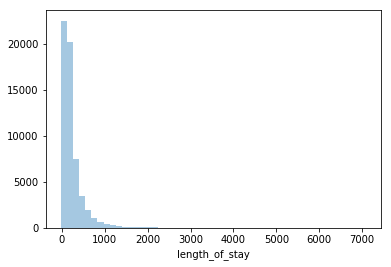

In [6]:
sns.distplot(admissions_df['length_of_stay'], kde=False)

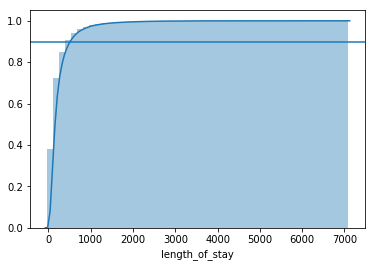

In [7]:
g = sns.distplot(admissions_df['length_of_stay'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
ax = g.axes
ax.axhline(.9)
plt.show()

### Filter out stays less than 4 hours or longer than 21 days AND patient is alive

In [8]:
time_too_short = ((admissions_df['length_of_stay'] > 24 * 21) & (admissions_df['HOSPITAL_EXPIRE_FLAG'] == 0)) | (admissions_df['length_of_stay'] < 4)

In [9]:
admissions_filtered_time = admissions_df[~time_too_short]

In [10]:
df_filtered_time = df[df['HADM_ID'].isin(admissions_filtered_time['HADM_ID'])]
df_filtered_time.drop(columns=['HADM_ID', 'bin_num'], inplace=True)

/Users/chriszhou/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
df_filtered_time.shape

(160110, 336)

### Remove Ethnicity

In [12]:
df_filtered_time = df_filtered_time.loc[:, ~df_filtered_time.columns.str.startswith('ethnicity')]

In [13]:
df_filtered_time['label'].value_counts()

0    155608
1      4502
Name: label, dtype: int64

### Add range feature from min and max

In [66]:
feature_col=df_filtered_time.columns.values
feature_col_mm=list(filter(lambda k: k.endswith('_max') or k.endswith('_min'), feature_col))
feature_col_mm.sort()
feature_col_mm
for i,k in zip(feature_col_mm[0::2], feature_col_mm[1::2]):
    col_name_new=i.split('_')[0]+"_range"
    df_filtered_time[col_name_new] = df_filtered_time[i]-df_filtered_time[k]

In [88]:
df_filtered_time.dtypes.index.to_list()

['Chloride_max',
 'Creatinine_max',
 'Glucose_max',
 'Hematocrit_max',
 'Hemoglobin_max',
 'Platelets_max',
 'Potassium_max',
 'Red blood cell count_max',
 'Sodium_max',
 'White blood cell count_max',
 'Chloride_min',
 'Creatinine_min',
 'Glucose_min',
 'Hematocrit_min',
 'Hemoglobin_min',
 'Platelets_min',
 'Potassium_min',
 'Red blood cell count_min',
 'Sodium_min',
 'White blood cell count_min',
 'Chloride_mean',
 'Creatinine_mean',
 'Glucose_mean',
 'Hematocrit_mean',
 'Hemoglobin_mean',
 'Platelets_mean',
 'Potassium_mean',
 'Red blood cell count_mean',
 'Sodium_mean',
 'White blood cell count_mean',
 'Diastolic blood pressure_max',
 'Glascow coma scale eye opening_max',
 'Glascow coma scale motor response_max',
 'Glascow coma scale verbal response_max',
 'Heart Rate_max',
 'Mean blood pressure_max',
 'Oxygen saturation_max',
 'Respiratory rate_max',
 'Systolic blood pressure_max',
 'Temperature_max',
 'Diastolic blood pressure_min',
 'Glascow coma scale eye opening_min',
 'Glasco

# We see that the classes are extremely imbalanced. Two ways of dealing with imbalanced data

## 1. downsample majority class

In [70]:
from sklearn.utils import resample
df_majority = df_filtered_time[df_filtered_time.label==0]
df_minority = df_filtered_time[df_filtered_time.label==1]
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 random_state=123)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
label_downsampled = df_downsampled['label'].copy()
df_downsampled.drop(columns=['label'], inplace=True)

## 2. upsample minority class

I noticed that if we upsample before train-test splitting, the same examples will show up one both sides and the model to over fit. So proper way to do this is do train test split before up sampling. Then only upsample the train set.

### Use stratified sampling

In [71]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=.25, random_state=42)
for train_index, test_index in split.split(df_filtered_time, df_filtered_time['label']):
    train_set = df_filtered_time.iloc[train_index, :]
    test_set = df_filtered_time.iloc[test_index, :]
df_majority = train_set[train_set.label==0]
df_minority = train_set[train_set.label==1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=100000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled_train = pd.concat([df_majority, df_minority_upsampled])
label_upsampled_train = df_upsampled_train['label'].copy()
df_upsampled_train.drop(columns=['label'], inplace=True)

label_upsampled_test = test_set['label'].copy()
df_upsampled_test = test_set.drop(columns=['label'])

In [73]:
label_upsampled_train.value_counts()

0    116706
1    100000
Name: label, dtype: int64

In [74]:
label_upsampled_test.value_counts()

0    38902
1     1126
Name: label, dtype: int64

In [75]:
label_og = df_filtered_time['label'].copy()
df_og = df_filtered_time.drop(columns=['label'])

# Now we are ready to screen some hyperparameters
### Define methods for removing certain features

In [135]:
from sklearn.preprocessing import FunctionTransformer
abnormal_cols = df_downsampled.columns[df_downsampled.columns.str.startswith('abnormal')]
abnormal_ix = [
    list(df_downsampled.columns).index(col)
    for col in abnormal_cols]
urine_ix = list(df_downsampled.columns).index('Urine output_sum')
range_cols = df_downsampled.columns[df_downsampled.columns.str.contains('range')]
range_ix = [
    list(df_downsampled.columns).index(col)
    for col in range_cols]
def range_remover(X, remove_range=False):
    if remove_range:
        X = np.delete(X, range_ix, axis=1)
    return X
def urine_remover(X, remove_urine=False):
    if remove_urine:
        X = np.delete(X, urine_ix, axis=1)
    return X
def abnormal_lab_sum(X, sum_abnormal_lab=True):
    if sum_abnormal_lab:
        abnormal_labs = X[:, abnormal_ix]
        sum_abnormal = np.sum(abnormal_labs, axis=1)
        X = np.c_[X, sum_abnormal]
    return X
def remove_abnormal(X, remove_abnormal_lab=False):
    if remove_abnormal_lab:
        X = np.delete(X, abnormal_ix, axis=1)
    return X

In [136]:
from sklearn.base import BaseEstimator, TransformerMixin
class Percent_na_remover(BaseEstimator, TransformerMixin):
    def __init__(self, percent_na=.45):
        self.percent_na = percent_na
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        nanvals = np.isnan(X)
        nans_per_col = np.count_nonzero(nanvals, axis=0)
        ix_to_remove = []
        for ix, num_nans in enumerate(nans_per_col):
            if (num_nans / X.shape[0]) > self.percent_na:
                ix_to_remove.append(ix)
        X = np.delete(X, ix_to_remove, axis=1)
        return X

### Construct pipeline for prepping data

In [171]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
prep_pipeline = Pipeline([
    ('range_remove', FunctionTransformer(range_remover, validate=False,
                                         kw_args={'remove_range': False})),
    ('urine_remove', FunctionTransformer(urine_remover, validate=False, 
                                         kw_args={'remove_urine': False})),
    ('abnormal_sum', FunctionTransformer(abnormal_lab_sum, validate=False, 
                                         kw_args={'sum_abnormal_lab': True})),
    ('remove_abnormal_labs', FunctionTransformer(remove_abnormal, validate=False, 
                                         kw_args={'remove_abnormal_lab': False})),
    ('remove_na_percent', Percent_na_remover()),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scalar', StandardScaler())
])

### To screen hyperparameters, we want one pipeline to feed into gridsearchCV

In [138]:
from sklearn.ensemble import RandomForestClassifier
prep_and_predict = Pipeline([
    ('prep', prep_pipeline),
    ('rnd', RandomForestClassifier(n_estimators=10, n_jobs=-1))
])

In [139]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

### parameter grid can be adjusted freely here

In [152]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = [{
    'prep__range_remove__kw_args': [{'remove_range': False}, {"remove_range": True}],
    'prep__urine_remove__kw_args': [{"remove_urine": True}],
    'prep__abnormal_sum__kw_args': [{"sum_abnormal_lab": True}],
    'prep__remove_abnormal_labs__kw_args': [{'remove_abnormal_lab': False}],
    'prep__remove_na_percent__percent_na': np.linspace(.3, .5, 20)
}]
grid_search = GridSearchCV(prep_and_predict, param_grid, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

### Tune hyperparameter with downsampled data to save time

In [153]:
grid_search.fit(df_downsampled.values, label_downsampled.values)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   23.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('range_remove', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function range_remover at 0x1a35ccd2f0>, inv_kw_args=None,
          inverse_func=None, kw_args={'remove_range': True},
          pass_y='deprecated', valid..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'prep__range_remove__kw_args': [{'remove_range': False}, {'remove_range': True}], 'prep__urine_remove__kw_args': [{'remove_urine': True}], 'prep__abnormal_sum__kw_args': [{'sum_abnormal_lab': True}], 'prep__remove_abnormal_labs__kw_args': [{'remove_abnormal_lab': False}], 'prep__remove_... 0.40526, 0.41579, 0.42632, 0.43684,
       0.44737, 0.45789, 0.46842, 0.4789

### After hyperparameter tuning, extract optimal model

We need to resplit data for final fitting

### Only run one of the 3 cells below

In [154]:
f1_best_param_downsample = grid_search.best_params_
f1_best_param_downsample

{'prep__abnormal_sum__kw_args': {'sum_abnormal_lab': True},
 'prep__range_remove__kw_args': {'remove_range': True},
 'prep__remove_abnormal_labs__kw_args': {'remove_abnormal_lab': False},
 'prep__remove_na_percent__percent_na': 0.34210526315789475,
 'prep__urine_remove__kw_args': {'remove_urine': True}}

In [155]:
result = grid_search.cv_results_
pd.DataFrame(result)

/Users/chriszhou/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chriszhou/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chriszhou/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_prep__abnormal_sum__kw_args,param_prep__range_remove__kw_args,param_prep__remove_abnormal_labs__kw_args,param_prep__remove_na_percent__percent_na,param_prep__urine_remove__kw_args,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.137500,0.006321,0.212318,0.006550,{'sum_abnormal_lab': True},{'remove_range': False},{'remove_abnormal_lab': False},0.3,{'remove_urine': True},{'prep__abnormal_sum__kw_args': {'sum_abnormal...,...,0.744410,0.741416,0.746562,0.005302,29,0.985361,0.988926,0.988440,0.987576,0.001579
1,1.171294,0.037142,0.181917,0.022383,{'sum_abnormal_lab': True},{'remove_range': False},{'remove_abnormal_lab': False},0.310526,{'remove_urine': True},{'prep__abnormal_sum__kw_args': {'sum_abnormal...,...,0.751393,0.751223,0.751255,0.000102,4,0.988926,0.987244,0.988271,0.988147,0.000692
2,1.070460,0.131942,0.215773,0.067600,{'sum_abnormal_lab': True},{'remove_range': False},{'remove_abnormal_lab': False},0.321053,{'remove_urine': True},{'prep__abnormal_sum__kw_args': {'sum_abnormal...,...,0.756625,0.744779,0.750966,0.004850,6,0.989767,0.987733,0.988930,0.988810,0.000835
3,1.018620,0.040075,0.231353,0.027403,{'sum_abnormal_lab': True},{'remove_range': False},{'remove_abnormal_lab': False},0.331579,{'remove_urine': True},{'prep__abnormal_sum__kw_args': {'sum_abnormal...,...,0.748166,0.744891,0.746565,0.001338,27,0.987410,0.986900,0.987248,0.987186,0.000213
4,1.087943,0.034242,0.181465,0.017718,{'sum_abnormal_lab': True},{'remove_range': False},{'remove_abnormal_lab': False},0.342105,{'remove_urine': True},{'prep__abnormal_sum__kw_args': {'sum_abnormal...,...,0.742261,0.752358,0.750490,0.006102,9,0.984864,0.987915,0.988779,0.987186,0.001680
5,0.955434,0.125532,0.217165,0.044865,{'sum_abnormal_lab': True},{'remove_range': False},{'remove_abnormal_lab': False},0.352632,{'remove_urine': True},{'prep__abnormal_sum__kw_args': {'sum_abnormal...,...,0.746425,0.742085,0.740943,0.005008,36,0.986891,0.988598,0.987567,0.987685,0.000702
6,0.982911,0.098988,0.249139,0.053878,{'sum_abnormal_lab': True},{'remove_range': False},{'remove_abnormal_lab': False},0.363158,{'remove_urine': True},{'prep__abnormal_sum__kw_args': {'sum_abnormal...,...,0.738227,0.733498,0.737963,0.003541,40,0.987576,0.987588,0.986886,0.987350,0.000328
7,1.118513,0.042608,0.180901,0.002954,{'sum_abnormal_lab': True},{'remove_range': False},{'remove_abnormal_lab': False},0.373684,{'remove_urine': True},{'prep__abnormal_sum__kw_args': {'sum_abnormal...,...,0.757000,0.734579,0.748410,0.009873,19,0.988575,0.987218,0.988753,0.988182,0.000685
8,0.835873,0.056908,0.215020,0.015352,{'sum_abnormal_lab': True},{'remove_range': False},{'remove_abnormal_lab': False},0.384211,{'remove_urine': True},{'prep__abnormal_sum__kw_args': {'sum_abnormal...,...,0.757054,0.747090,0.753497,0.004539,2,0.985400,0.987915,0.990776,0.988031,0.002196
9,1.003268,0.093463,0.209023,0.034101,{'sum_abnormal_lab': True},{'remove_range': False},{'remove_abnormal_lab': False},0.394737,{'remove_urine': True},{'prep__abnormal_sum__kw_args': {'sum_abnormal...,...,0.748782,0.738745,0.747072,0.006217,24,0.987074,0.987899,0.988919,0.987964,0.000754


In [156]:
grid_search.best_score_

0.759568099943448

### Feed best params into data prep pipline alone, no model

In [174]:
best = {'range_remove__kw_args': {'remove_range': True},
    'abnormal_sum__kw_args': {'sum_abnormal_lab': True},
 'remove_abnormal_labs__kw_args': {'remove_abnormal_lab': False},
 'remove_na_percent__percent_na': 0.4,
 'urine_remove__kw_args': {'remove_urine': True}}

In [175]:
prep_pipeline.set_params(**best)

Pipeline(memory=None,
     steps=[('range_remove', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function range_remover at 0x1a35ccd2f0>, inv_kw_args=None,
          inverse_func=None, kw_args={'remove_range': True},
          pass_y='deprecated', validate=False)), ('urine_remove', FunctionTrans...egy='median', verbose=0)), ('std_scalar', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [176]:
# Renaming upsampled data
X_train = df_upsampled_train.values
X_test = df_upsampled_test.values
y_train = label_upsampled_train.values
y_test = label_upsampled_test.values

In [184]:
# Splitting downsampled data
final_model = grid_search.best_estimator_
split = StratifiedKFold(n_splits=4, random_state=42)
for train_index, test_index in split.split(df_downsampled, label_downsampled):
    X_train = df_downsampled.iloc[train_index, :].values
    X_test = df_downsampled.iloc[test_index, :].values
    y_train = label_downsampled.iloc[train_index].values
    y_test = label_downsampled.iloc[test_index].values

In [322]:
# Splitting original data
final_model = grid_search.best_estimator_
split = StratifiedKFold(n_splits=4, random_state=42)
for train_index, test_index in split.split(df_og, label_og):
    X_train = df_og.iloc[train_index, :].values
    X_test = df_og.iloc[test_index, :].values
    y_train = label_og.iloc[train_index].values
    y_test = label_og.iloc[test_index].values

### Fitting final model with training set

In [185]:
X_train_prepped = prep_pipeline.fit_transform(X_train)
X_test_prepped = prep_pipeline.transform(X_test)

In [186]:
X_train_prepped.shape

(7127, 294)

In [187]:
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=2)

In [188]:
rnd_clf.fit(X_train_prepped, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s


building tree 1 of 100building tree 2 of 100building tree 3 of 100


building tree 4 of 100building tree 5 of 100

building tree 6 of 100
building tree 7 of 100building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100building tree 12 of 100building tree 13 of 100


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100building tree 29 of 100

building tree 30 of 100building tree 31 of 100

building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [189]:
from sklearn import metrics
y_pred = rnd_clf.predict_proba(X_test_prepped)[:, 1]
prec_n, rec_n, _ = metrics.precision_recall_curve(y_test, y_pred)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


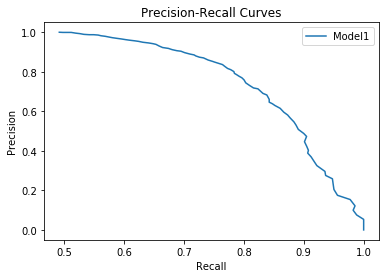

In [190]:
plt.plot(prec_n, rec_n, label = "Model1")
# plt.plot(prec2, rec2, label = "Model2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

In [168]:
y_pred_binary = final_model.predict(X_test)

In [169]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_binary)


array([[1243,    7],
       [  23, 1102]])

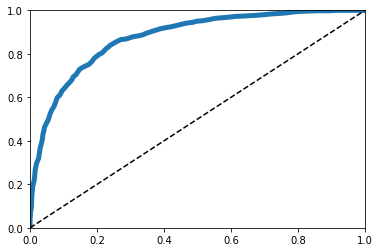

In [170]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=5, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    
plot_roc_curve(fpr, tpr)

### For fun, try a classifier that always predicts alive

In [352]:
class AliveClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((X.shape[0], 1), dtype=bool)

In [354]:
alive_predictor = AliveClassifier()
zeros = alive_predictor.predict(X_test)
prec_zero, rec_zero, _ = metrics.precision_recall_curve(y_test, zeros)


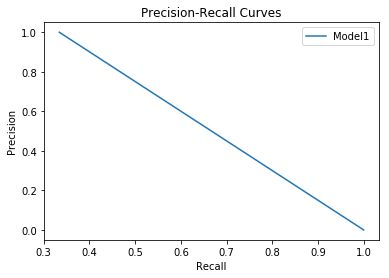

In [355]:
plt.plot(prec_zero, rec_zero, label = "Model1")
# plt.plot(prec2, rec2, label = "Model2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

# Anything below this is scratch work
### One option is to drop all rows containing any na

In [13]:
df_dropped_any = df_filtered_time.dropna()

In [14]:
df_dropped_any['label'].value_counts()

0    12897
1     3488
Name: label, dtype: int64

In [15]:
labels = df_dropped_any.pop('label').values
df_dropped_any = df_dropped_any.values

In [16]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skf.split(df_dropped_any, labels):
    X_train, X_test = df_dropped_any[train_index],df_dropped_any[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scalar', StandardScaler())
])
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

/Users/chriszhou/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [43]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [44]:
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
y_pred = rnd_clf.predict_proba(X_test)[:, 1]

In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

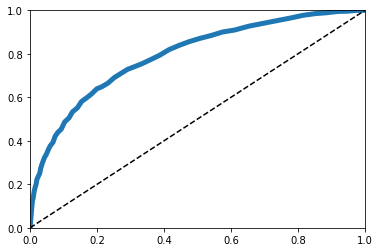

In [51]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=5, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    
plot_roc_curve(fpr, tpr)

In [52]:
prec1, rec1, thresholds1 = metrics.precision_recall_curve(y_test, y_pred)

### If we only drop urine and use median imputation

In [53]:
df_filtered_time.drop(columns=['Urine output_sum'], inplace=True)
labels = df_filtered_time.pop('label').values
df_filtered_time = df_filtered_time.values

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [54]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skf.split(df_filtered_time, labels):
    X_train, X_test = df_filtered_time[train_index],df_filtered_time[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [55]:
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

In [56]:
y_pred = rnd_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]

In [57]:
prec2, rec2, thresholds2 = metrics.precision_recall_curve(y_test, y_pred)

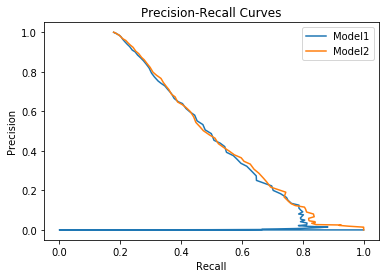

In [58]:
plt.plot(prec1, rec1, label = "Model1")
plt.plot(prec2, rec2, label = "Model2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

### SVMs

In [59]:
from sklearn.svm import LinearSVC
svm = LinearSVC(class_weight='balanced', C=1.0, verbose=2, max_iter=5000)

In [61]:
svm.fit(X_train, y_train)

[LibLinear]

/Users/chriszhou/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=5000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=2)

In [62]:
y_pred = svm.decision_function(X_test)
prec3, rec3, thresholds3 = metrics.precision_recall_curve(y_test, y_pred)

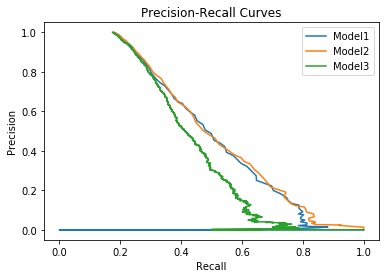

In [63]:
plt.plot(prec1, rec1, label = "Forest Drop all na")
plt.plot(prec2, rec2, label = "Forest impute median")
plt.plot(prec3, rec3, label = "SVM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

### Simple Neural Network

In [64]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
cv = StratifiedKFold(n_splits = 4)

param_grid = {
    'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50), (100, 100)]
}

In [65]:
bst_grid = GridSearchCV(
    estimator = MLPClassifier(),
    param_grid = param_grid,
    cv = cv,
    scoring = 'f1', 
    verbose = 3,
    n_jobs = -1)
bst_grid.fit(X_train, y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   56.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  1.7min remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50), (100, 100)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=3)

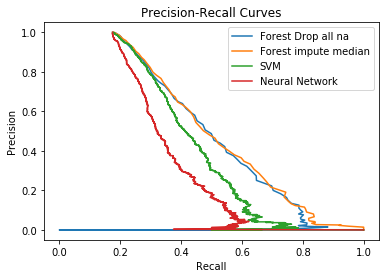

In [66]:
y_pred = bst_grid.best_estimator_.predict_proba(X_test)[:,1]
prec4, rec4, thresholds4 = metrics.precision_recall_curve(y_test, y_pred)
plt.plot(prec1, rec1, label = "Forest Drop all na")
plt.plot(prec2, rec2, label = "Forest impute median")
plt.plot(prec3, rec3, label = "SVM")
plt.plot(prec4, rec4, label = "Neural Network")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()


### Adaboost

In [74]:
from sklearn.ensemble import AdaBoostClassifier
rnd_clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
ada_clf = AdaBoostClassifier(learning_rate=.5)

In [75]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=None)

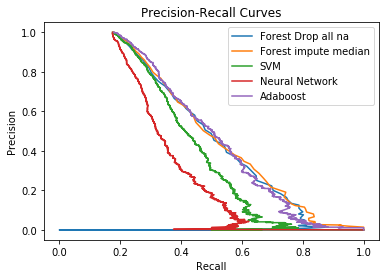

In [76]:
y_pred = ada_clf.predict_proba(X_test)[:, 1]
prec5, rec5, thresholds5 = metrics.precision_recall_curve(y_test, y_pred)
plt.plot(prec1, rec1, label = "Forest Drop all na")
plt.plot(prec2, rec2, label = "Forest impute median")
plt.plot(prec3, rec3, label = "SVM")
plt.plot(prec4, rec4, label = "Neural Network")
plt.plot(prec5, rec5, label = "Adaboost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

### Removed Abnormal Labs

In [77]:
df_filtered_time_only_abnormal_sum.drop(columns=['Urine output_sum'], inplace=True)
labels = df_filtered_time_only_abnormal_sum.pop('label').values
df_filtered_time_only_abnormal_sum = df_filtered_time_only_abnormal_sum.values

In [78]:
for train_index, test_index in skf.split(df_filtered_time, labels):
    X_train, X_test = df_filtered_time_only_abnormal_sum[train_index],df_filtered_time_only_abnormal_sum[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [79]:
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)
y_pred = rnd_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]

In [80]:
prec7, rec7, thresholds7 = metrics.precision_recall_curve(y_test, y_pred)

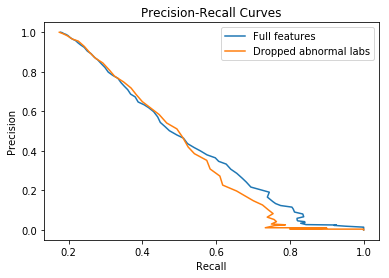

In [81]:
plt.plot(prec2, rec2, label = "Full features")
plt.plot(prec7, rec7, label = "Dropped abnormal labs")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

In [82]:
X_train.shape

(23013, 71)